In [1]:
# Basic Data Manipulation
import pandas as pd
import numpy as np
import re
# Information Extraction
from openie import StanfordOpenIE
# Calssify
from nltk.corpus import verbnet as vn
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.symbols import dobj, obj, pobj, acomp, ccomp, pcomp, xcomp, conj, acomp, ccomp, pcomp, xcomp, advmod, amod
from spacy.symbols import neg, det, aux, prep, poss, nsubj, nsubjpass, csubj, csubjpass, det, prt
from spacy.symbols import VERB, AUX, DET, ADP, ADV, ADJ, NOUN, PRON, PROPN, PART
from spacy.tokenizer import Tokenizer
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex

In [3]:
### Extract
# ref: https://github.com/philipperemy/stanford-openie-python
def extract_triple(text):
    with StanfordOpenIE() as client:
        return client.annotate(text)

In [4]:
### Select
# for similar jsons, keep the shortest json 
# include triples with and without the dataset_prediction (for possible coref)

# Helper: count the "longest" object
def long_stuff(compare_stuff):  # a list of objects, return a list of longest objects
    stf = pd.DataFrame()
    stf["stuff"] = compare_stuff
    stf["len"] = stf.stuff.apply(lambda x: x.count(" "))  # a list of object length
    return stf.stuff[stf.len.idxmax()]  # we only interested in one object - the longest
    # later, we can extract more info from the long object


# Helper: get the stuff that are not a subject of others
def no_subset(A):  # a list of strings
    return list(set([x for x in A if not any(x in y and x != y for y in A)]))


# Helper: Using rules to select tri:
def select_triple(triplets):
    """
    Extract a equence of subject-verb-object (SVO) triples
    from a opie_tri fucntion acquired and processed doc,
    including both active and passive entities and actions.

    Args:
        triplets are lists of dictionaries;
        assume number of triplets >=2, i.e. len(triplets)>=2.

    Yields:
        List of dictionaries: the main/longest triplets from ``triplets``
        representing a (subject, verb, object) triple.
    """
    # initiate
    selected = []
    # only extract the longest subject
    compare_sub = list(map(lambda x: x["subject"], triplets))
    subjects = no_subset(compare_sub)
    for sub in subjects:
        # extract different unique relations
        tri_for_this_sub = [d for d in triplets if d["subject"] == sub]
        compare_rel = list(map(lambda x: x["relation"], tri_for_this_sub))
        relations = no_subset(compare_rel)
        # for each of the relation, extract the longest obeject
        for rel in relations:
            tri_for_this_rel = [d for d in tri_for_this_sub if d["relation"] == rel]
            compare_obj = list(map(lambda x: x["object"], tri_for_this_rel))
            this_object = long_stuff(compare_obj)
            selected.append({"subject": sub, "relation": rel, "object": this_object})

    # for the selected ones, if both subject and object are the same
    # we keep the one with the longest relation
    if len(selected) > 1:
        # initiate
        re_select = []

        # give group number
        group_list = [0] * len(selected)
        group_list[0] = 1  # initiate the first group
        group_num = 1
        pos = 0
        # if both subject and object are the same
        # assign the same group number
        # but avoid reassignment
        for i in range(len(selected)):
            pos = i
            for j in range(i + 1, len(selected)):
                pos += 1
                if group_list[pos] == 0:
                    if selected[i]["subject"] == selected[j]["subject"] and \
                            selected[i]["object"] == selected[j]["object"]:
                        group_list[pos] = group_num
                    else:
                        group_list[pos] = group_num + 1
            group_num += 1

        # for each group, find the longest relation
        numbers = list(set(group_list))
        selected_df = pd.DataFrame()
        selected_df["tri"] = selected
        selected_df["grp"] = group_list
        for num in numbers:
            # find all the triplets for this group
            tri_for_this_grp = selected_df[selected_df.grp == num].tri
            # acquire a list of relations in this group
            compare_rel = list(map(lambda x: x["relation"], tri_for_this_grp))
            # find the longest relation
            this_rel = long_stuff(compare_rel)
            # get the subjects and objects for this group
            # since these values are the same for each one of the values
            # we extract the first one
            this_subject = list(tri_for_this_grp)[0]["subject"]  # change a series to a list
            this_object = list(tri_for_this_grp)[0]["object"]  # change a series to a list
            # all the triplets in this group to the list
            re_select.append({"subject": this_subject, "relation": this_rel, "object": this_object})

        return re_select

    return selected

In [5]:
### Classify

# Subjects and Objects
# identify "I" and "we" 
# detect (probably not full currently) dataset in part or in ful

def find_author(text):
    '''
    input: full sentence (text)
    output: bool of find or not
    '''
    text_lower = text.lower()
    words = text_lower.split()
    if ("i" in words or "we" in words):
        return True
    return False

data_keywords = ['data', 'data\s*(?:set|base)s?', 'corp(us|ora)', 'tree\s*bank', 
            '(?:train|test|validation|testing|trainings?)\s*(?:set)',
            'collections?', 'benchmarks?', 'surveys?', 'samples?', 'stud(y|ies)']
data_pattern= re.compile(r'\b(' + '|'.join(data_keywords) + r')\b', flags = re.IGNORECASE)

def find_dataset(text,data_name):
    '''
    input: full sentence (text) and dataset_prediction (data_name)
    output: bool of find or not
    '''
    # use predicted dataset names to find
    data_name_list = data_name.split()
    words = text.split()
    for data_name_token in data_name_list: # anything match counts
        if data_name_token in words:
            return True
    
    # use data citation pattern to find
    if re.search(data_pattern,text):
        return True
    
    return False

In [6]:
# Relations

# ref: https://verbs.colorado.edu/verb-index/VerbNet_Guidelines.pdf
# https://docs.google.com/spreadsheets/d/18kn2z2df-M4ncUmoHPGqbs5nJyGL-k9R0d2slXdT830/edit?usp=sharing
verb_class_df = pd.read_csv("VerbNet_LF.csv")
verb_class = verb_class_df.drop("Verb Class",axis=1).set_index("Class Number").to_dict()['Verb Type']

def get_classes(classids):
    """
    input VerbNet classids (long)
    output a set of VerbNet classes (parenent-level, short)
    """
    classes = set()
    for classid in classids:
        # remove the word itself
        this_classid_long = classid.split("-")[1]
        # get the class -- the string upto the first non-digit
        this_classid_short = int(re.search(r'(\d+)',this_classid_long).group(1))
        classes.add(this_classid_short)
    return classes

def get_rel_classes(rel_nlp):
    rel_classes = set()
    for token in rel_nlp:
        token_lemma = token.lemma_
        token_classids = vn.classids(token_lemma)
        token_classes = get_classes(token_classids)
        rel_classes.update(token_classes)
    return rel_classes

In [7]:
# AEO Categories (tentative)
# ref: https://github.com/lizhouf/semantic_triplets/blob/main/scr/add_aeo.py

# clauses are characterized by:
# - temporal organization (the order in which the subject narrates events and actions in the story), 
# - evaluative description (personal assessments made by the narrator), and 
# - contextual orientation (usually information provided by the narrator that helps orient the listener)

# ref: Labov and Waletsky 1997 Labov, William, and Joshua Waletzky. 1997. “Narrative Analysis: Oral Versions of Personal Experience.” Journal of Narrative & Life History 7 (1–4): 3–38.

# We have: 
# - Active Agency
# - Passive Agency
# - Possible Agency
# - Evaluative Description
# - Contextual Orientation


# Example Key Words
evaluation_verbs = ["feel","smell","taste","look","hear","see","think","know"]
orientation_verbs = ["remember","bear","grow","belong"]
imagine_verbs = ["want","should","would","could","can","might","may"]

def get_cat(this_rel, this_obj):
    '''
    input spaCy Spans this_rel, this_obj 
    output category result
    '''
    
    # initate category result
    
    this_cat = ""

    # initiate the rule components

    rel_has_evaluation = 0
    rel_has_orientation = 0
    rel_has_imagine = 0

    rel_has_be = 0
    rel_has_have = 0
    rel_has_to = 0

    rel_has_neg = 0

    rel_has_VBG = 0
    rel_num_verb = 0

    obj_is_adj = 0  # only adj, no NOUN+

    obj_has_no = 0
    
    # give value
    for rel in this_rel:

        # rel lemmas
        try:
            if rel.lemma_ in evaluation_verbs:
                rel_has_evaluation = 1
            if rel.lemma_ in imagine_verbs:
                rel_has_imagine = 1
            if rel.lemma_ in orientation_verbs:
                rel_has_orientation = 1
            if rel.lemma_ == "be":
                rel_has_be = 1
            if rel.lemma_ == "have":
                rel_has_have = 1
            if rel.lemma_ == "to":
                rel_has_to = 1
        except:  # avoid no lemma
            0

        # rel dep
        try:
            if rel.dep == neg:
                rel_has_neg = 1
        except:
            0

        # rel pos
        try:
            if (rel.pos == VERB or rel.pos == AUX):
                rel_num_verb = rel_num_verb + 1
        except:
            0

        # rel tag
        try:
            if rel.tag_ == "VBG":
                rel_has_VBG = 1
        except:
            0

    for obj in this_obj:
        
        # obj lemma
        try:
            if obj.lemma_ == "no":
                obj_has_no = 1
        except:
            0

    for obj in this_obj:  # seperate, want to break
        # obj pos
        try:
            if obj.pos == ADJ:
                obj_is_adj = 1
            if obj.pos in [NOUN,PRON,PROPN]:
                obj_is_adj = 0
                break
        except:
            0

    # judge:

    # fixed words
    if rel_has_evaluation and obj_is_adj:
        this_cat ="Evaluation"
    elif rel_has_imagine:
        this_cat ="Agency_Possible"
    elif rel_has_orientation:
        this_cat ="Orientation"

    # neg
    elif rel_has_neg or obj_has_no:
        this_cat ="Orientation"

    # have
    elif rel_has_have:
        if rel_has_to:
            this_cat ="Agency_Passive" # no longer coercive
        else:
            this_cat ="Orientation"

    # be
    elif rel_has_be:
        if obj_is_adj:
            this_cat ="Evaluation"
        elif rel_has_VBG:
            this_cat ="Agency_Active"
        elif rel_num_verb > 1:
            this_cat ="Agency_Passive"
        elif rel_num_verb == 1:
            this_cat ="Orientation"

    # if none of the above, then assign active:
    else:
        this_cat = "Agency_Active"

    return this_cat

In [2]:
### Import and Manipulate Data
citations = pd.read_csv("/nfs/turbo/hrg/data_detection/outputs_pipeline/4_pubs_sents_preds_ids.csv")
citations_true = citations[~citations.dataset_prediction.isna()].reset_index(drop=True)

In [3]:
citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402637 entries, 0 to 402636
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   paper_id            402637 non-null  int64 
 1   paper_title         364875 non-null  object
 2   paper_section       379748 non-null  object
 3   sentence_text       402637 non-null  object
 4   dataset_prediction  7486 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.4+ MB


In [4]:
citations.head()

,paper_id,paper_title,paper_section,sentence_text,dataset_prediction
0,1102332573,Do Political Institutions Affect the Choice of...,NaN,Do political institutions affect the choice of...,NaN
1,1102332573,Do Political Institutions Affect the Choice of...,Introduction,Foreign firms from a wide set of countries con...,NaN
2,1102332573,Do Political Institutions Affect the Choice of...,Introduction,Firms can cross-list their shares in the U.S. ...,NaN
3,1102332573,Do Political Institutions Affect the Choice of...,Introduction,Firms that decide to cross-list on U.S. market...,NaN
4,1102332573,Do Political Institutions Affect the Choice of...,Introduction,"Alternatively, foreign firms can choose unlist...",NaN


In [5]:
citations_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   paper_id            7486 non-null   int64 
 1   paper_title         6754 non-null   object
 2   paper_section       6948 non-null   object
 3   sentence_text       7486 non-null   object
 4   dataset_prediction  7486 non-null   object
dtypes: int64(1), object(4)
memory usage: 292.5+ KB


In [4]:
len(set(citations_true.paper_id)) # >1k papers

1074

In [15]:
#%%timeit

# Initiate result df
df = pd.DataFrame(columns=["paper_id","sentence_text","dataset_prediction",
                           "subject","relation","object",
                           "subject_category","relation_categories","object_category","AEO_category"])

with StanfordOpenIE() as client:
    for i in range(len(citations_true)):
    #for i in range(10): # test
        paper_id = citations_true.paper_id[i]
        sentence_text = citations_true.sentence_text[i]
        dataset_prediction = citations_true.dataset_prediction[i]
        # Extract triple
        triples = client.annotate(sentence_text)
        # Select triple
        triples_selected = select_triple(triples)

        # loop
        for triple in triples_selected:
            sub = str(triple["subject"]) # ensure string, not int or bool
            rel = str(triple["relation"])
            rel_nlp = nlp(rel)
            obj = str(triple["object"])
            # Subject
            Subject_Cat = "author" if find_author(sub) else "dataset" if find_dataset(sub,dataset_prediction) else "other"
            # Object
            Object_Cat = "author" if find_author(obj) else "dataset" if find_dataset(obj,dataset_prediction) else "other"
            # Relation
            Relation_Cats = get_rel_classes(rel_nlp)
            # AEO
            AEO_Cat = get_cat(rel_nlp,nlp(obj))
            # Append
            df.loc[len(df.index)] = [paper_id, sentence_text, dataset_prediction,
                                     sub, rel, obj, 
                                     Subject_Cat, Relation_Cats, Object_Cat, AEO_Cat] 


Starting server with command: java -Xmx8G -cp /home/lizhouf/stanfordnlp_resources/stanford-corenlp-full-2018-10-05/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-02dab20cacdf497a.props -preload openie


In [16]:
df.to_csv("ICPSR_bib_data_citation_rhetoric_v01.csv",index=False)

We are more interested in the columns with at least one author or dataset.

## More on classification

In [2]:
df = pd.read_csv("ICPSR_bib_data_citation_rhetoric_v01.csv")

### FIltering
Using subjects + objects as filters: some combinations doesn't make sense. This will filter the irrelevant triples.

In [18]:
df.head()

,paper_id,sentence_text,dataset_prediction,subject,relation,object,subject_category,relation_categories,object_category,AEO_category,SO_Category
0,1102332573,ADR data are collected from the major deposita...,ADR,New York,of Bank is,Deutsche Bank,other,set(),other,Orientation,0
1,1102332573,ADR data are collected from the major deposita...,ADR,ADR data,are collected from,major depositary bank websites,dataset,"{13, 22, 26, 45, 47}",other,Agency_Passive,4
2,1102332573,For the non-ADR cross-listed shares (direct li...,ADR AMEX,firms,type from,NYSE websites,other,{25},other,Agency_Active,0
3,1102332573,For the non-ADR cross-listed shares (direct li...,ADR AMEX,firms,obtain name For,listing,other,"{29, 13}",other,Agency_Active,0
4,1102332573,The political institution variables are: the p...,XCONST,1,being,ideal perceived political institution efficiency,other,set(),other,Agency_Active,0


In [4]:
### Subject Object Category (S&O)
# 1: Subject: author, Object: dataset
# 2: Subject: author, Object: other
# 3: Subject: dataset, Object: dataset
# 4: Subject: dataset, Object: other
# 5: Subject: other, Object: dataset
# all others: 0

SO_Category_list = []

for i in range(len(df)):
    subject_category = df.subject_category[i]
    object_category = df.object_category[i]
    this_SO_Category = 0
    
    if subject_category == "author":
        if object_category == "dataset":
            this_SO_Category = 1
        elif object_category == "other":
            this_SO_Category = 2
    elif subject_category == "dataset":
        if object_category == "dataset":
            this_SO_Category = 3
        elif object_category == "other":
            this_SO_Category = 4
    elif subject_category == "other":
        if object_category == "dataset":
            this_SO_Category = 5
    
    SO_Category_list.append(this_SO_Category)

df["SO_Category"] = SO_Category_list

In [5]:
df_new = df[df.SO_Category!=0].reset_index(drop=True)

In [8]:
# proportion counting
len(df_new)/len(df)

0.5859367443659929

In [53]:
df.to_csv("ICPSR_bib_data_citation_rhetoric_v01.csv",index=False)

In [54]:
df_new.to_csv("ICPSR_bib_data_citation_rhetoric_v02.csv",index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10339 entries, 0 to 10338
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             10339 non-null  int64 
 1   sentence_text        10339 non-null  object
 2   dataset_prediction   10339 non-null  object
 3   subject              10339 non-null  object
 4   relation             10339 non-null  object
 5   object               10339 non-null  object
 6   subject_category     10339 non-null  object
 7   relation_categories  10339 non-null  object
 8   object_category      10339 non-null  object
 9   AEO_category         10339 non-null  object
 10  SO_Category          10339 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 888.6+ KB


In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6058 entries, 0 to 6057
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             6058 non-null   int64 
 1   sentence_text        6058 non-null   object
 2   dataset_prediction   6058 non-null   object
 3   subject              6058 non-null   object
 4   relation             6058 non-null   object
 5   object               6058 non-null   object
 6   subject_category     6058 non-null   object
 7   relation_categories  6058 non-null   object
 8   object_category      6058 non-null   object
 9   AEO_category         6058 non-null   object
 10  SO_Category          6058 non-null   int64 
dtypes: int64(2), object(9)
memory usage: 520.7+ KB


### Relations
Extract, Count, and Visualize verb lemmas

In [34]:
df_new.head()

,paper_id,sentence_text,dataset_prediction,subject,relation,object,subject_category,relation_categories,object_category,AEO_category,SO_Category,verb_lemmas
0,1102332573,ADR data are collected from the major deposita...,ADR,ADR data,are collected from,major depositary bank websites,dataset,"{13, 22, 26, 45, 47}",other,Agency_Passive,4,[collect]
1,1102223384,In addition to linking our results to existing...,National Organizations Survey 1996,firms,is in,National Organizations Survey,other,set(),dataset,Orientation,5,[]
2,1102223384,In addition to linking our results to existing...,National Organizations Survey 1996,autonomy,is in,sample of firms,other,set(),dataset,Orientation,5,[]
3,1102223384,The data are drawn from the National Organizat...,National Organizations Survey 1996 97 and 2002,data,are drawn from,National Organizations Survey,dataset,"{26, 23, 25, 10, 59}",dataset,Agency_Passive,3,[draw]
4,1033523023,This study makes the first effort to examine t...,CHIP survey China Household Income Project,impact,is in,urban China,other,set(),dataset,Orientation,5,[]


In [9]:
# Extract verb lemmas from relations
all_lemmas = []
verb_lemmas_list = []
for doc in nlp.pipe(df_new['relation'].astype(str).values):
    this_lemmas_list = []
    for token in doc:
        if token.pos == VERB:
            all_lemmas.append(token.lemma_)
            this_lemmas_list.append(token.lemma_)
    verb_lemmas_list.append(this_lemmas_list)
df_new["verb_lemmas"] = verb_lemmas_list

len(all_lemmas)

3877

In [12]:
# Count
from collections import Counter
all_lemmas_count = Counter(all_lemmas)

In [36]:
df_verb_lemmas = pd.DataFrame.from_dict(all_lemmas_count, orient='index').reset_index()
df_verb_lemmas.rename(columns={'index': 'verb_lemma', 0: 'counts'}, inplace=True)

In [37]:
df_verb_lemmas.head()

,verb_lemma,counts
0,collect,95
1,draw,45
2,use,554
3,derive,27
4,base,108


In [50]:
# add sentences
all_sentences_lists = []

for i in range(len(df_verb_lemmas)):
    this_verb_lemma = df_verb_lemmas.verb_lemma[i]
    this_sentences_list = []
    for j in range(len(df_new)):
        if this_verb_lemma in df_new.verb_lemmas[j]:
            this_sentence = df_new.sentence_text[j]
            this_sentences_list.append(this_sentence)
    all_sentences_lists.append(this_sentences_list)

df_verb_lemmas["sentences"] = all_sentences_lists

In [51]:
# export
df_verb_lemmas.to_csv("ICPSR_bib_data_citation_verb_lemmas.csv",index=False)

In [31]:
# Visualize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

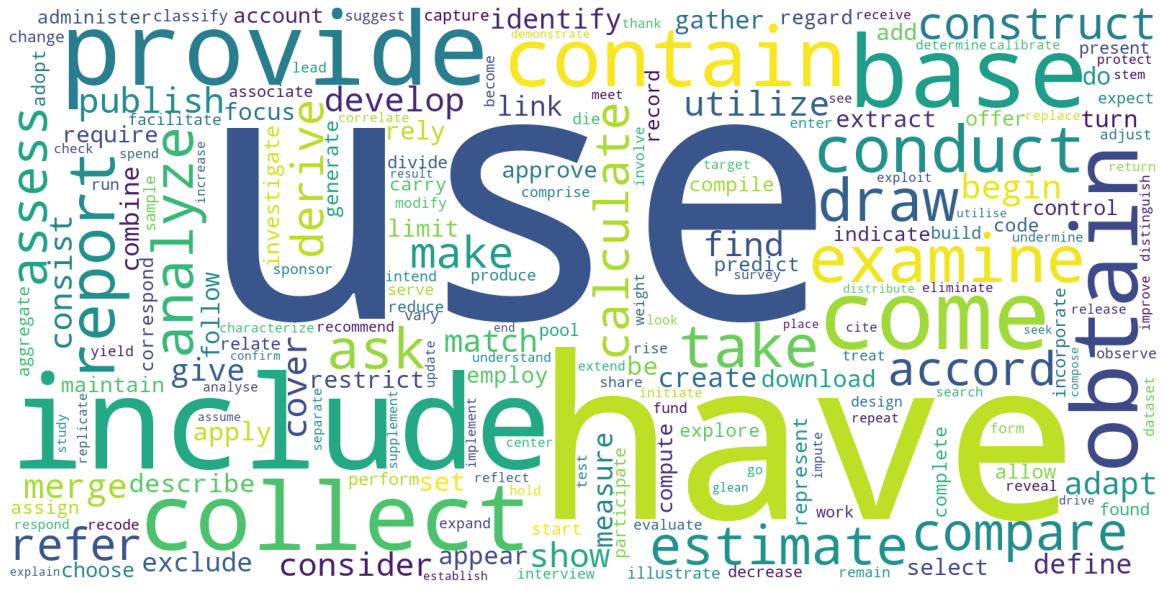

In [33]:
# create the WordCloud
wordcloud = WordCloud(width = 1600,
                      height = 800,
                      background_color ='white').generate_from_frequencies(all_lemmas_count)
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Assign 25 categories

In [7]:
df_new = pd.read_csv("ICPSR_bib_data_citation_rhetoric_v02.csv")

In [8]:
df_new

,paper_id,sentence_text,dataset_prediction,subject,relation,object,subject_category,relation_categories,object_category,AEO_category,SO_Category,verb_lemmas
0,1102332573,ADR data are collected from the major deposita...,ADR,ADR data,are collected from,major depositary bank websites,dataset,"{13, 22, 26, 45, 47}",other,Agency_Passive,4,['collect']
1,1102223384,In addition to linking our results to existing...,National Organizations Survey 1996,firms,is in,National Organizations Survey,other,set(),dataset,Orientation,5,[]
2,1102223384,In addition to linking our results to existing...,National Organizations Survey 1996,autonomy,is in,sample of firms,other,set(),dataset,Orientation,5,[]
3,1102223384,The data are drawn from the National Organizat...,National Organizations Survey 1996 97 and 2002,data,are drawn from,National Organizations Survey,dataset,"{26, 23, 25, 10, 59}",dataset,Agency_Passive,3,['draw']
4,1033523023,This study makes the first effort to examine t...,CHIP survey China Household Income Project,impact,is in,urban China,other,set(),dataset,Orientation,5,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
6053,1039138747,"Under the Office of Mental Health Promotion, a...",Adult Survey Data Use,granted permission,utilize,data,other,set(),dataset,Agency_Active,5,['utilize']
6054,1008356823,Supplementary Homicide Reports (SHRs) include ...,Supplementary Homicide Reports,Supplementary Homicide Reports,include,incident-level data on reported homicide inclu...,dataset,{65},dataset,Agency_Active,3,['include']
6055,1008356823,"Second, and more generally, the FBI SHR databa...",SHR,FBI SHR database,Second is limited in,breadth of information provided on homicide,dataset,{76},other,Agency_Passive,4,['limit']
6056,1102413948,Transatlantic Trends has conducted a yearly su...,Transatlantic Trends,Transatlantic Trends,has conducted,yearly survey on foreign policy issues,dataset,{51},dataset,Orientation,3,['conduct']


In [9]:
### Subject Object Category (S&O)
# 1: Subject: author, Object: dataset
# 2: Subject: author, Object: other
# 3: Subject: dataset, Object: dataset
# 4: Subject: dataset, Object: other
# 5: Subject: other, Object: dataset
# all others: 0

### AEO Category
# a: Agency_Active
# b: Agency_Passive
# b: Agency_Possible
# c: Orientation
# d: Evaluation

ALL_Category_list = []

AEO_dict = {
    "Agency_Active":"a",
    "Agency_Passive":"b",
    "Agency_Possible":"c",
    "Orientation":"d",
    "Evaluation":"e"
}

for i in range(len(df_new)):
    SO_Category = df_new.SO_Category[i]
    AEO_Category = df_new.AEO_category[i]
    this_ALL_Category = ""
    
    if SO_Category in [1,2,3,4,5] and AEO_Category in ["Agency_Active","Agency_Passive","Agency_Possible","Orientation","Evaluation"]:
        this_SO_str = str(SO_Category)
        this_AEO_str = AEO_dict[AEO_Category]
        this_ALL_Category = this_SO_str+this_AEO_str
    
    if len(this_ALL_Category)!=2:
        this_ALL_Category=""
    
    ALL_Category_list.append(this_ALL_Category)

df_new["Category"] = ALL_Category_list

In [11]:
df_new = df_new[df_new.Category!=""].reset_index(drop=True)
df_new.to_csv("ICPSR_bib_data_citation_rhetoric_v03.csv",index=False)